# Pre-Req:

In [1]:
#Project Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, GridSearchCV
from sklearn.metrics import mean_squared_log_error, make_scorer, label_ranking_average_precision_score
from xgboost import XGBRegressor, XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
#Creating datframe from test csv
TrainDataset = pd.read_csv('/content/train.csv')
#Creating dataframe from test csv
TestDataset = pd.read_csv('/content/test.csv')

#Creating some additional dataframes to not be encoded
TrainNoEncDataset = pd.read_csv('/content/train.csv')
TestNoEncDataset = pd.read_csv('/content/test.csv')

# Data Clean-Up:



*   Train Dataset:


In [3]:
TrainDataset.head()

,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,1,27,69,65,Sandy,Millets,30,6,18,28-28
2,2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,4,35,58,43,Red,Paddy,37,2,16,DAP


In [4]:
#Check for null inputs
TrainDataset.isnull().sum()

,0
id,0
Temparature,0
Humidity,0
Moisture,0
Soil Type,0
Crop Type,0
Nitrogen,0
Potassium,0
Phosphorous,0
Fertilizer Name,0


In [5]:
#Encoding TrainDataset - Making the Dataset numeric for machine learning purposes

##########################################################################Encoding##########################################################################

#Intialise encoder
le = LabelEncoder()

############################Soil Type
TrainDataset['Soil Type'] = le.fit_transform(TrainDataset['Soil Type'])
############################Crop Type
TrainDataset['Crop Type'] = le.fit_transform(TrainDataset['Crop Type'])
############################Crop Type
TrainDataset['Fertilizer Name'] = le.fit_transform(TrainDataset['Fertilizer Name'])
#For the model
TrainDataset['Fertilizer Name Encoded'] = le.fit_transform(TrainDataset['Fertilizer Name'])

In [6]:
#Check Traindataset is completley numeric

all_numeric = TrainDataset.applymap(lambda x: isinstance(x, (int, float))).all().all()

print(f"Are all values numeric? {all_numeric}")

/tmp/ipython-input-6-956717985.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  all_numeric = TrainDataset.applymap(lambda x: isinstance(x, (int, float))).all().all()


Are all values numeric? True




*   Test Dataset:




In [7]:
#Observe Dataset in unmodified form
TestDataset.head()

,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous
0,750000,31,70,52,Sandy,Wheat,34,11,24
1,750001,27,62,45,Red,Sugarcane,30,14,15
2,750002,28,72,28,Clayey,Ground Nuts,14,15,4
3,750003,37,53,57,Black,Ground Nuts,18,17,36
4,750004,31,55,32,Red,Pulses,13,19,14


In [8]:
#Check for null inputs
TestDataset.isnull().sum()

,0
id,0
Temparature,0
Humidity,0
Moisture,0
Soil Type,0
Crop Type,0
Nitrogen,0
Potassium,0
Phosphorous,0


In [9]:
#Encoding TrainDataset - Making the Dataset numeric for machine learning purposes

##########################################################################Encoding##########################################################################

#Intialise encoder
le = LabelEncoder()

############################Soil Type
TestDataset['Soil Type'] = le.fit_transform(TestDataset['Soil Type'])
############################Crop Type
TestDataset['Crop Type'] = le.fit_transform(TestDataset['Crop Type'])

In [10]:
#Check Traindataset is completley numeric

all_numeric = TestDataset.applymap(lambda x: isinstance(x, (int, float))).all().all()

print(f"Are all values numeric? {all_numeric}")

/tmp/ipython-input-10-2570449884.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  all_numeric = TestDataset.applymap(lambda x: isinstance(x, (int, float))).all().all()


Are all values numeric? True


# Data Analysis:

In [11]:
#Basic Look
TrainNoEncDataset.head()

,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,1,27,69,65,Sandy,Millets,30,6,18,28-28
2,2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,4,35,58,43,Red,Paddy,37,2,16,DAP


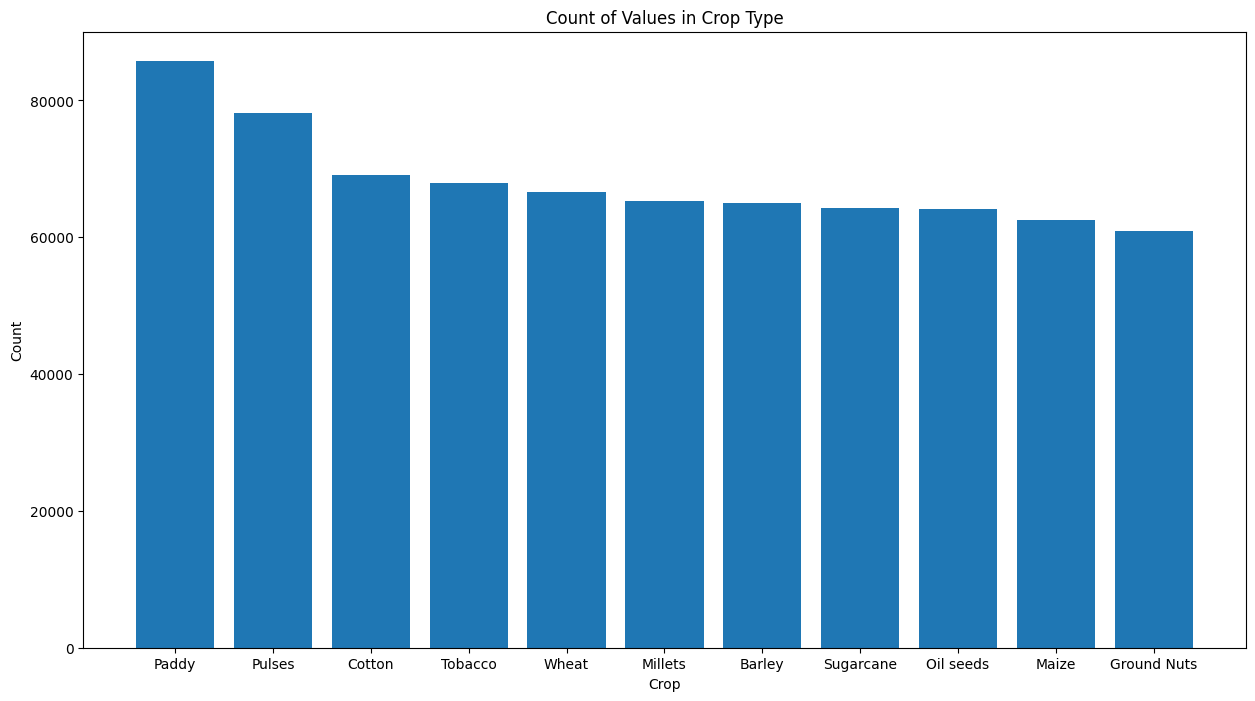

In [ ]:
#Counts of crop type
CountsOfCrop = TrainNoEncDataset['Crop Type'].value_counts()
plt.figure(figsize=(15, 8))
# Plot bar chart
plt.bar(CountsOfCrop.index, CountsOfCrop.values)
plt.xlabel('Crop')
plt.ylabel('Count')
plt.title('Count of Values in Crop Type')
plt.show()

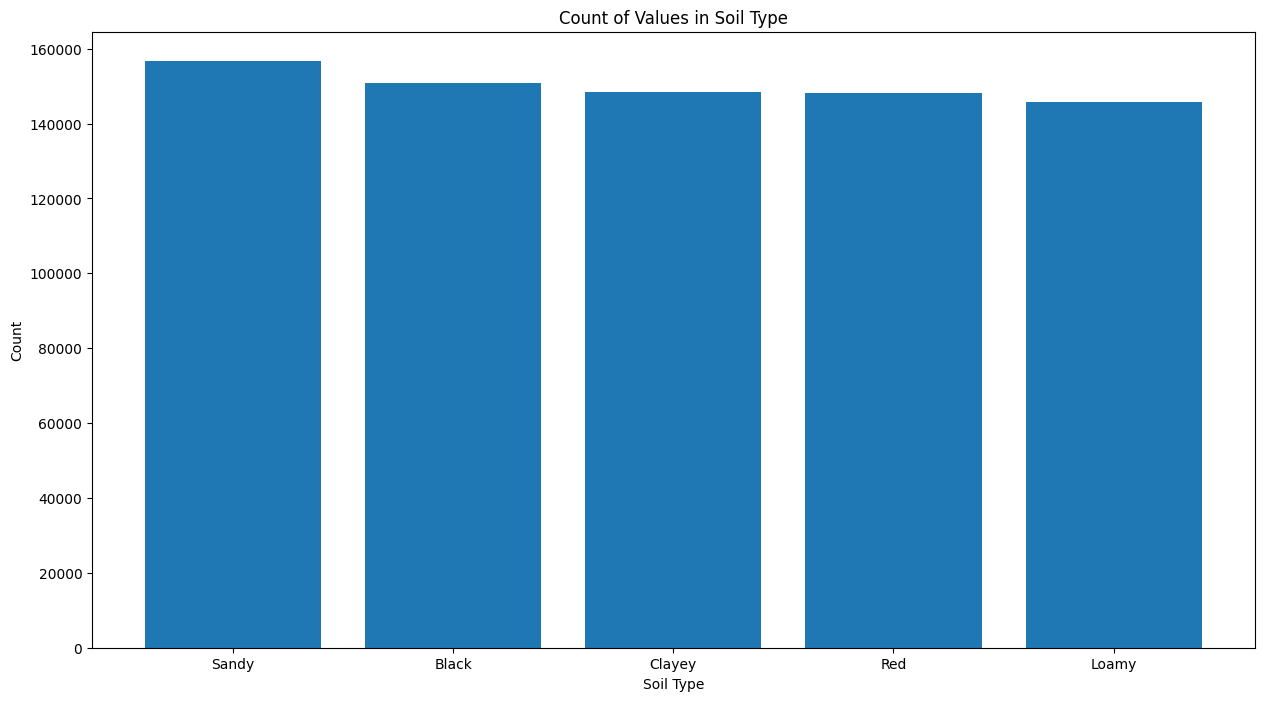

In [ ]:
#Counts of soil type
CountsOfSoil = TrainNoEncDataset['Soil Type'].value_counts()
plt.figure(figsize=(15, 8))
# Plot bar chart
plt.bar(CountsOfSoil.index, CountsOfSoil.values)
plt.xlabel('Soil Type')
plt.ylabel('Count')
plt.title('Count of Values in Soil Type')
plt.show()

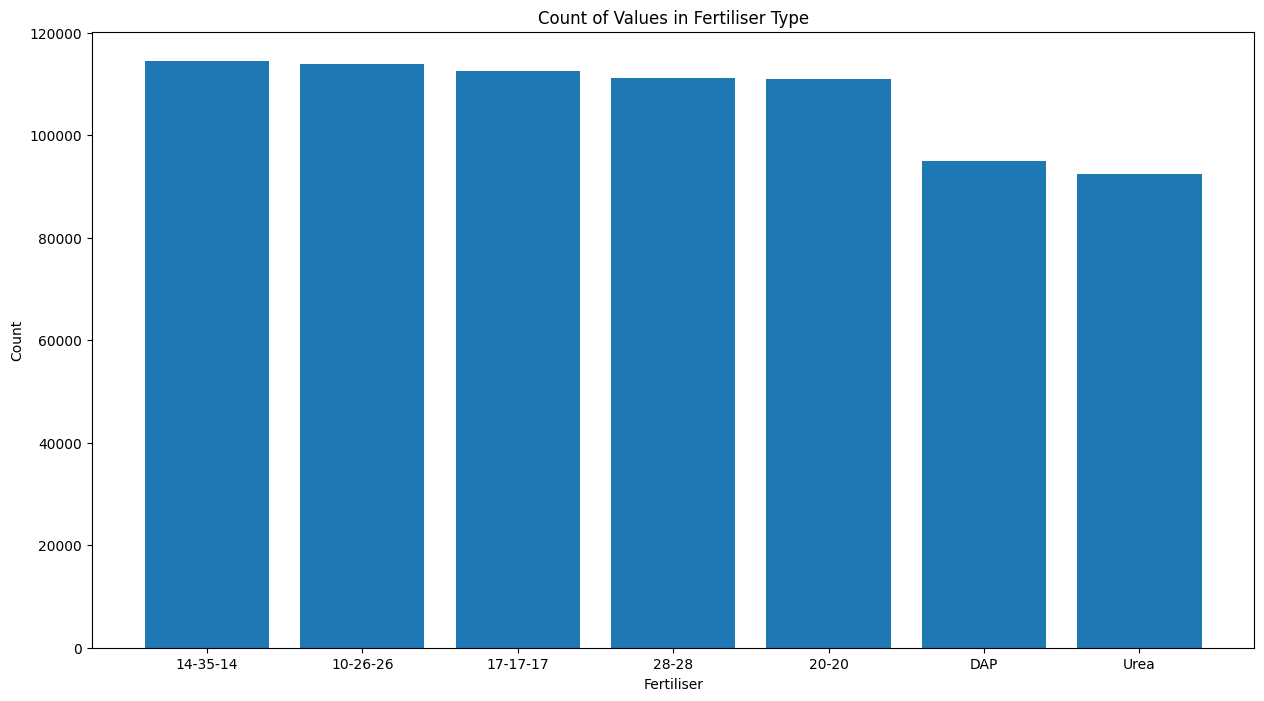

In [ ]:
#Counts of fertiliser type
CountsOfFert = TrainNoEncDataset['Fertilizer Name'].value_counts()
plt.figure(figsize=(15, 8))
# Plot bar chart
plt.bar(CountsOfFert.index, CountsOfFert.values)
plt.xlabel('Fertiliser')
plt.ylabel('Count')
plt.title('Count of Values in Fertiliser Type')
plt.show()

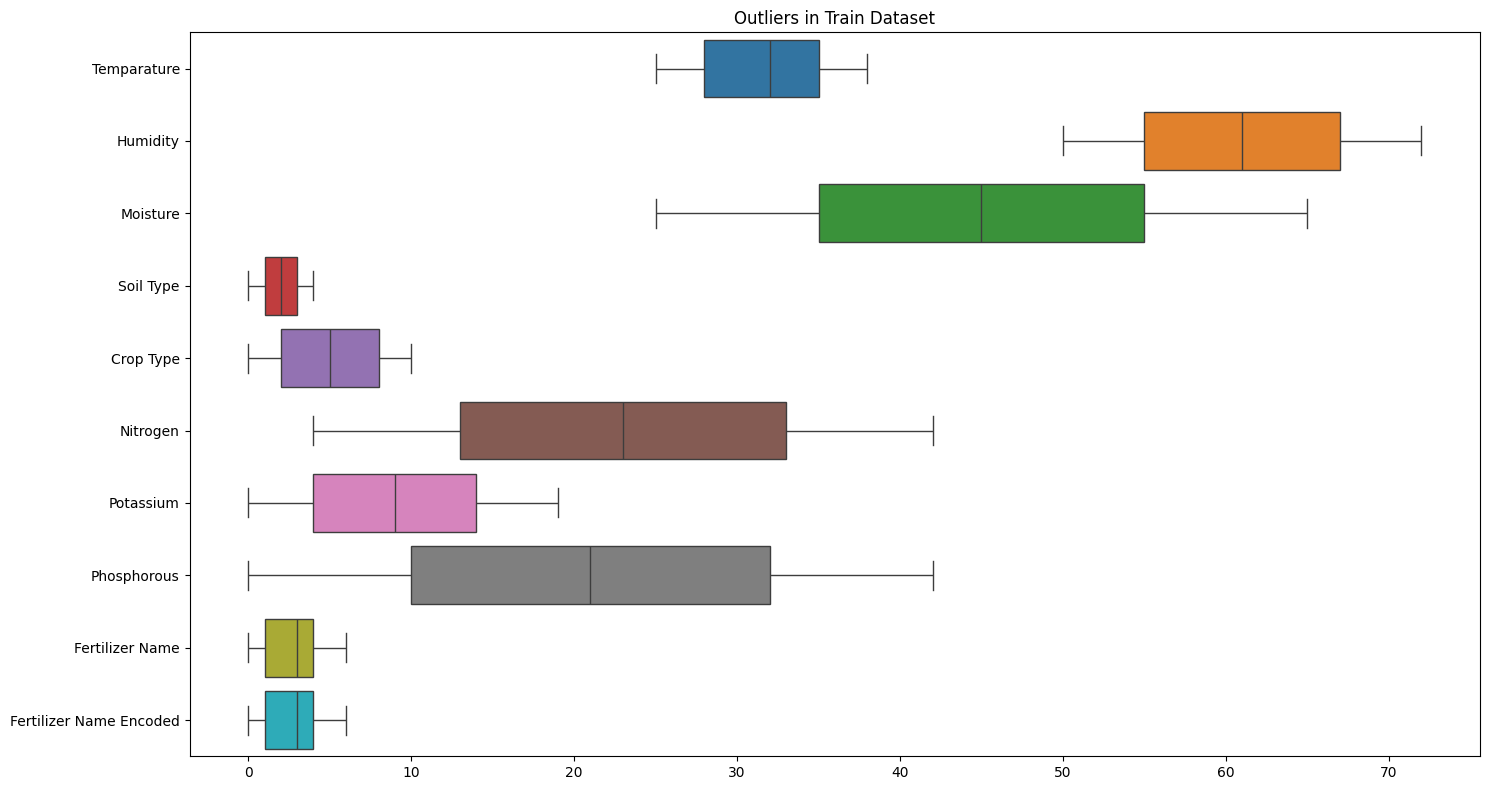

In [ ]:
#Check for outliers in traindataset

numeric_cols = TrainDataset.select_dtypes(include='number').drop(columns=['id'])

# Create box plots for all numeric columns
plt.figure(figsize=(15, 8))
sns.boxplot(data=numeric_cols, orient='h')
plt.title('Outliers in Train Dataset')
plt.tight_layout()
plt.show()

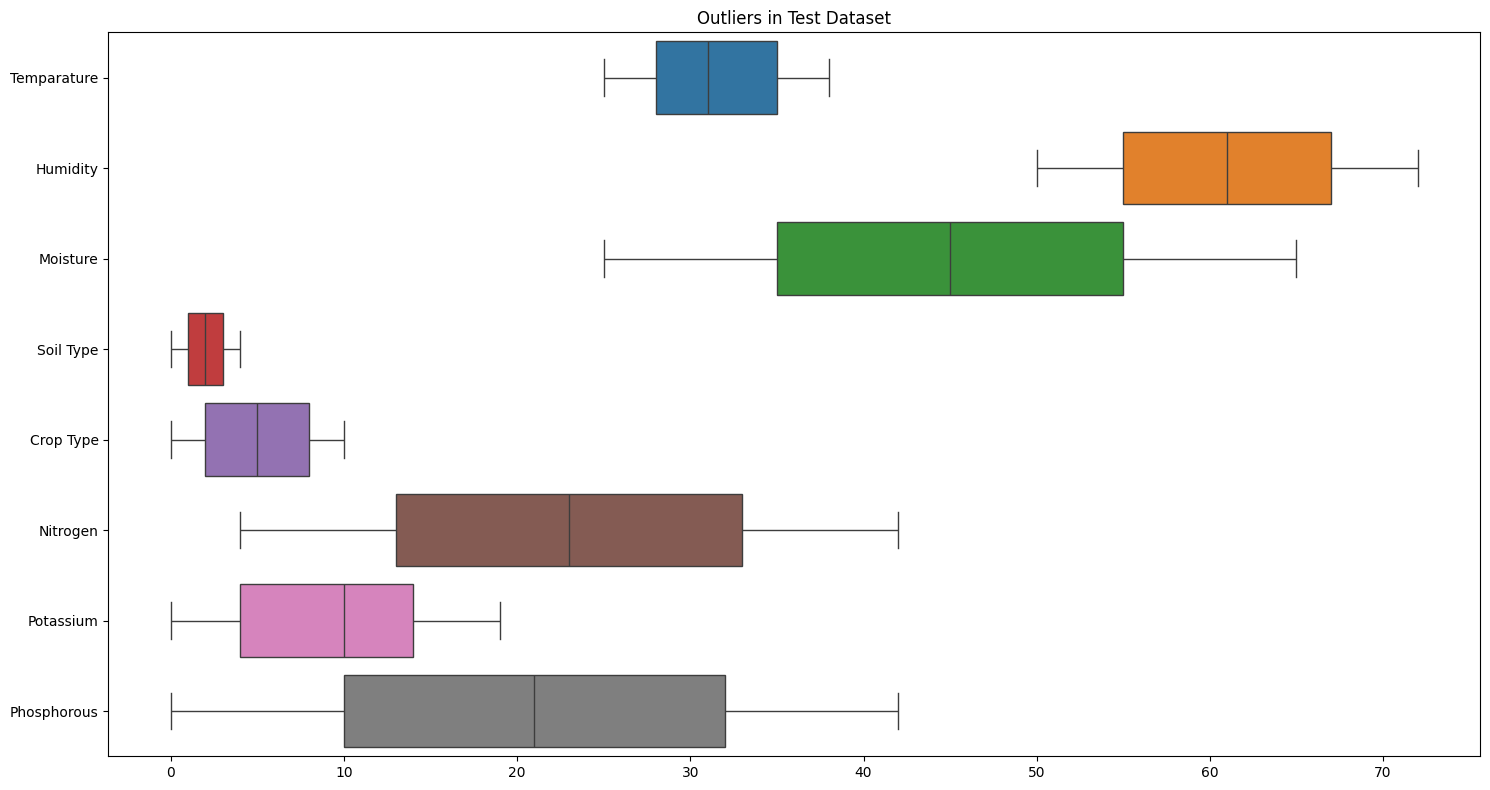

In [ ]:
#Check for outliers in testdataset

numeric_cols = TestDataset.select_dtypes(include='number').drop(columns=['id'])

# Create box plots for all numeric columns
plt.figure(figsize=(15, 8))
sns.boxplot(data=numeric_cols, orient='h')
plt.title('Outliers in Test Dataset')
plt.tight_layout()
plt.show()

array([[<Axes: title={'center': 'Temparature'}>,
        <Axes: title={'center': 'Humidity'}>,
        <Axes: title={'center': 'Moisture'}>],
       [<Axes: title={'center': 'Soil Type'}>,
        <Axes: title={'center': 'Crop Type'}>,
        <Axes: title={'center': 'Nitrogen'}>],
       [<Axes: title={'center': 'Potassium'}>,
        <Axes: title={'center': 'Phosphorous'}>,
        <Axes: title={'center': 'Fertilizer Name'}>]], dtype=object)

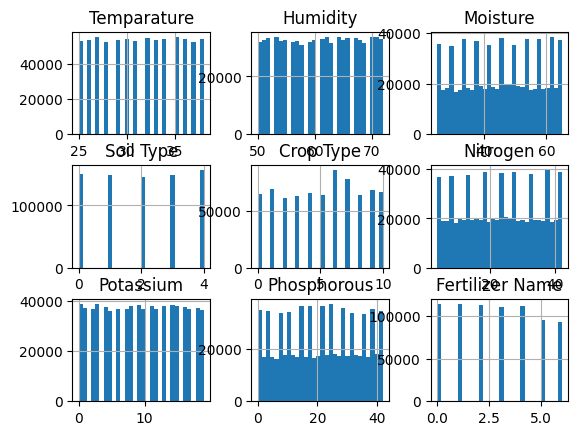

In [ ]:
#Looking for skewed data
TrainDataset[['Temparature', 'Humidity',	'Moisture',	'Soil Type',	'Crop Type',	'Nitrogen',	'Potassium',	'Phosphorous',	'Fertilizer Name']].hist(bins=30)

In [ ]:
#Drop Fertilizer Name Encoded
TrainDataset = TrainDataset.drop('Fertilizer Name Encoded', axis=1)

# Model 1 - Random Forest:

In [ ]:
# 2. Prepare features and labels
X_train = TrainDataset.drop(['id', 'Fertilizer Name'], axis=1)
y_train = TrainDataset['Fertilizer Name']  # Already encoded as integers

X_test = TestDataset.drop(['id'], axis=1)
test_ids = TestDataset['id']

# 3. Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 4. Predict probabilities for test data
probs = model.predict_proba(X_test)

# 5. Get top-3 predictions per sample
top_3_preds = np.argsort(probs, axis=1)[:, -3:][:, ::-1]

# 6. Manual decoding: fill in your actual fertilizer names here
label_map = {
    0: '28-28',
    1: '17-17-17',
    2: '10-26-26',
    3: 'DAP',
    4: '20-20',
    5: '14-35-14',
    6: 'Urea'
    # Add or adjust keys as needed based on your data
}

# 7. Decode predictions using the manual map
decoded_preds = [
    ' '.join([label_map[i] for i in preds]) for preds in top_3_preds
]

# 8. Create submission DataFrame
submission = pd.DataFrame({
    'id': test_ids,
    'Fertilizer Name': decoded_preds
})

# 9. Save to CSV
submission.to_csv('SubmissionRandomForestKaggle.csv', index=False)

# Model 2 - XGBoost:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train = TrainDataset.drop(['id', 'Fertilizer Name'], axis=1)
y_train = TrainDataset['Fertilizer Name']
X_test = TestDataset.drop(['id'], axis=1)
test_ids = TestDataset['id']


param_grid = {
    'n_estimators': [40,50,80],
    'max_depth': [20, 50, 75],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree' : [0.2, 0.3, 0.5, 0.8],
    'min_child_weight' : [3, 5, 9],
    'gamma' : [0.2, 0.4],
    'random_state' : [42, 52]
}

xgb_model = xgb.XGBClassifier()

grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')


grid_search.fit(X_train, y_train)

# 4. Predict probabilities
probs = grid_search.predict_proba(X_test)

# 5. Get top-3 predictions per sample
top_3_preds = np.argsort(probs, axis=1)[:, -3:][:, ::-1]

# 6. Manual decoding (FILL THIS IN based on your dataset)
label_map = {
    0: '28-28',
    1: '17-17-17',
    2: '10-26-26',
    3: 'DAP',
    4: '20-20',
    5: '14-35-14',
    6: 'Urea'
    # Add or adjust keys as needed based on your data
}

# 7. Decode top-3 predictions
decoded_preds = [
    ' '.join([label_map[i] for i in preds]) for preds in top_3_preds
]

# 8. Create submission DataFrame
submission = pd.DataFrame({
    'id': test_ids,
    'Fertilizer Name': decoded_preds
})

# 9. Save submission to CSV
submission.to_csv('SubmissionXGBoostKaggle.csv', index=False)